In [6]:
#Import statements 
import scipy
import scipy.linalg
from scipy.linalg import expm, norm, eigvals, solve, toeplitz, eig, eigh, inv
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib import rc
import time
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

#Fonts and stuff 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [997]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [623]:

def twopBVP(fvec, alpha, beta, L, N):
    """Solves a two value boundry problem on the domain (0,L) with fvec in the right hand side and dirichlet conditions
    alpha and beta.
    param fvec: np.ndarray, function values of right hand side in vector
    param alpha: float, dirichlet condition at 0
    param beta: float, dirichlet condition at L
    param L: float, domain length
    param N: int, number of gridpoint
    return x: np.ndarray: the grid that solution was computed on and endpoints to that grid
    retunrn y: np.ndarray: the numerical solution with values at endpoints attatched
    """
    delta_x = L / (N+1)
    x = np.linspace(delta_x, L-delta_x, N)
    A = toeplitz(np.concatenate([np.array([-2,1]), np.zeros(N-2)], axis = 0),
         np.concatenate([np.array([-2,1]), np.zeros(N-2)], axis = 0)) / delta_x**2
    b = np.copy(fvec)
    b[0] = b[0] - alpha / delta_x**2 
    b[-1] = b[-1] - beta / delta_x**2
    y = np.linalg.solve(A, b)
    x = np.append(x, L)
    x = np.insert(x, 0, 0)
    y = np.append(y, beta)
    y = np.insert(y, 0, alpha)
    return x,y

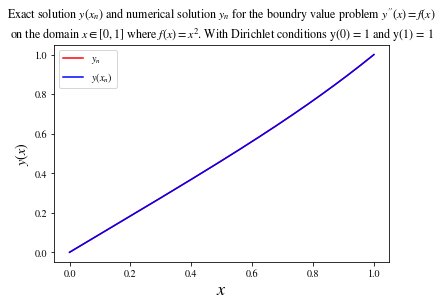

In [955]:
alpha = 0
beta = 1
L = 1
N = 1000
delta_x = L / (N+1)
fvec = np.square(np.linspace(delta_x, L-delta_x, N))
x, y = twopBVP(fvec, alpha, beta, L, N)
y_exact = 1 / 12 * (x**4 + 11 * x)
plt.plot(x, y, color = 'red', label = "$y_n$")
plt.plot(x,y_exact, color = 'blue', label = "$y(x_n)$");
plt.title("Exact solution $y(x_n)$ and numerical solution $y_n$ for the boundry value problem $y''(x) = f(x)$ \n"
+ "on the domain $x \in [0,1]$ where $f(x) = x^2$. With Dirichlet conditions y(0) = 1 and y(1) = 1")
plt.xlabel("$x$", fontsize = 18) 
plt.ylabel("$y(x)$", fontsize = 14) 
plt.legend()
reg = LinearRegression().fit(np.log(delta_xs).reshape(-1,1), np.log(errors))


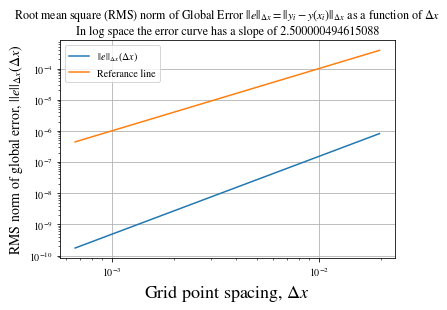

In [999]:
Ns = [50*k for k in range(1,31)]
delta_xs = []
errors = []
test = []
for N in Ns:
    delta_x = L / (N+1)
    delta_xs.append(delta_x)
    
    fvec = np.square(np.linspace(delta_x, L-delta_x, N))
    x, y = twopBVP(fvec, alpha, beta, L, N)
    y_exact = 1 / 12 * (x**4 + 11 * x)
    error = norm(y-y_exact,ord=2)/(N+1) #Using RMS norm
    errors.append(error)
    test.append(delta_x**2)
plt.loglog(delta_xs, errors, label = "$||e||_{ \Delta x}(\Delta x)$")
plt.loglog(delta_xs, test, label = "Referance line")
plt.title("Root mean square (RMS) norm of Global Error $||e||_{ \Delta x} = ||y_i-y(x_i)||_{ \Delta x}$ as a function of $\Delta x$ \n"
         + "In log space the error curve has a slope of " + str(reg.coef_[0]))
plt.xlabel("Grid point spacing, $\Delta x$", fontsize = 18) 
plt.ylabel("RMS norm of global error, $||e||_{ \Delta x} (\Delta x)$", fontsize = 14) 
reg = LinearRegression().fit(np.log(delta_xs).reshape(-1,1), np.log(errors))

plt.grid()
reg.coef_[0]
plt.legend()

In [1005]:
#1.2
L = 10 #[m]
E = 1.9e11 #[Nm^-2]
alpha = 0
beta = 0
N = 999
delta_x = L / (N+1)

x = np.linspace(delta_x, L-delta_x, N)
q = -50e3 * np.ones(len(x)) #[Nm^-1]
I = 10**(-3) * (3 - 2*np.cos(np.pi * x / L)**12)

_,M = twopBVP(q, alpha, beta, L, N)
M = np.delete(M,0)
M = np.delete(M,-1)
x_with_boundries,u = twopBVP(M/(E*I), alpha, beta, L, N)

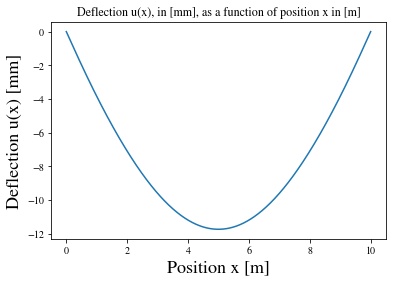

In [1006]:
plt.plot(x_with_boundries,u*10**3)
plt.ylabel("Deflection u(x) [mm]", fontsize = 18)
plt.xlabel("Position x [m]", fontsize = 18)
plt.title("Deflection u(x), in [mm], as a function of position x in [m]");

In [1007]:
defl_at_mid = u[int(len(u)/2)]
defl_at_mid_mm = np.abs(defl_at_mid)*10**3
print("The deflection at the beam's midpoint is " +
      str( defl_at_mid_mm ) + " [mm] ")

The deflection at the beam's midpoint is 11.741059085875692 [mm] 


In [1004]:
np.abs(u[np.where(x_with_boundries == 5)])[0]*10**3

11.743528336092561

In [111]:
def twopEVP(N, L):
    """Two point eigenvalue problem solver (Ay = lambda y) for homogeneus Dirichlet and Neuman conditions (in that order) with A = d^2/dx^2 
    param N: int, number of gridpoints
    param L: float, length of domain
    return eigvals: np.ndarray, the computed eigenvalues
    return eigvecs: np.ndarray, the computed eigenvectors, including endpoint values
    return x: The grid used for computation with endpoints attatched"""
    
    delta_x = 1 / (N+1/2) #because of Neuman condition at L, using approach 2
    x = np.linspace(delta_x,L-delta_x,N)
    
    #Define matrix representation of d^2/dx^2 operator
    A = toeplitz(np.concatenate([np.array([-2,1]), np.zeros(N-2)], axis = 0),
         np.concatenate([np.array([-2,1]), np.zeros(N-2)], axis = 0)) / delta_x**2
    A[-1][-1] = -1/delta_x**2 ##Neuman condition changes matrix representation
    eigvals, eigvecs = eigh(A)
    
    #Flip eigvecs and eigvals to get in "increasing" (absolute) order
    eigvecs = np.flip(eigvecs)
    eigvecs = np.flip(eigvecs, axis=0)
    eigvals = np.flip(eigvals)
    
    #Append boundry values to eigenvectors
    eigvecs = np.vstack([np.zeros(len(eigvecs[0])), eigvecs])
    eigvecs = np.vstack([eigvecs,eigvecs[-1]])
    
    #have eigvecs returned as rows instead of columns to avoid confusion
    eigvecs = np.transpose(eigvecs)
    
    #append the endpoints to match for plotting
    x = np.append(x, L)
    x = np.insert(x, 0, 0)
    
    return eigvals, eigvecs, x

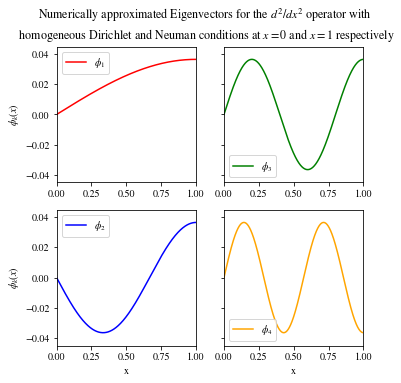

In [112]:
N = 1500
L = 1
eigvals, eigvecs, x = twopEVP(N,L)
fig1, axs = plt.subplots(2,2, figsize=[5.5, 5.5], sharex= False, sharey = True)
axs[0][0].plot(x,eigvecs[0], color = "red", label = "$\phi_1$")
axs[1][0].plot(x,eigvecs[1], color = "blue", label = "$\phi_2$")
axs[0][1].plot(x,eigvecs[2], color = "green", label = "$\phi_3$")
axs[1][1].plot(x,eigvecs[3], color = "orange", label = "$\phi_4$")
plt.setp(axs, xlim=(0,L), ylim=(-0.045,0.045));
axs[0][0].legend()
axs[1][0].legend()
axs[0][1].legend()
axs[1][1].legend();
fig1.suptitle("Numerically approximated Eigenvectors for the $d^2/dx^2$ operator with \n homogeneous Dirichlet and Neuman conditions"
             +" at $x = 0$ and $x = 1$ respectively");
axs[1][0].set(xlabel='x', ylabel='$\phi_k(x)$')
axs[0][0].set(ylabel='$\phi_k(x)$')
axs[1][1].set(xlabel='x');

In [99]:
df = pd.DataFrame()
exact_eigenvalues = [-(np.pi*(1/2+k))**2 for k in range(0,1500)]
df['Computed EigenValues'] = eigvals.tolist()
df['Exact eigenvalues'] = exact_eigenvalues
df[0:200]

,Computed EigenValues,Exact eigenvalues
0,-2.465757,-2.467401
1,-22.191795,-22.206610
2,-61.643784,-61.685028
3,-120.821552,-120.902654
4,-199.724839,-199.859489
...,...,...
195,-371733.572821,-377218.747611
196,-375492.275320,-381087.632536
197,-379269.057872,-384976.256670
198,-383063.903922,-388884.620013


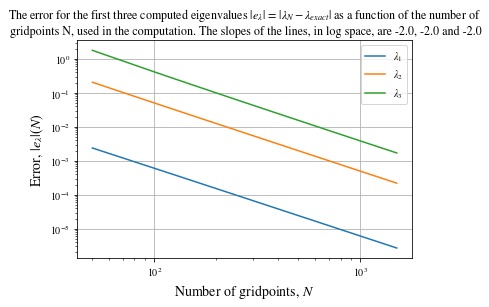

In [101]:
Ns = [50*k for k in range(1,31)]
errors = np.empty((1,3))
test = []
L = 1
eigvals_exact = exact_eigenvalues[0:3]
for i in range(len(Ns)):
    
    eigvals,_,_ = twopEVP(Ns[i], L)
    eigvals_3 = eigvals[:3]
    error = np.abs(eigvals_3-eigvals_exact)**2
    errors = np.vstack((errors,error))

errors = np.delete(errors, (0), axis=0)
plt.loglog(Ns, errors[:,0], label = "$\lambda_1$")
plt.loglog(Ns, errors[:,1], label = "$\lambda_2$")
plt.loglog(Ns, errors[:,2], label = "$\lambda_3$")
plt.legend()

plt.grid()

reg0 = LinearRegression().fit(np.log(Ns).reshape(-1,1), np.log(errors[:,0]))
reg1 = LinearRegression().fit(np.log(Ns).reshape(-1,1), np.log(errors[:,1]))
reg2 = LinearRegression().fit(np.log(Ns).reshape(-1,1), np.log(errors[:,2]))
coefs = [reg0.coef_[0],reg1.coef_[0],reg2.coef_[0]]

plt.title("The error for the first three computed eigenvalues $|e_{\lambda}|$ = $|\lambda_N - \lambda_{exact}|$"
         +" as a function of the number of \n gridpoints N, used in the computation. The slopes of the lines, in log space, " 
          +"are " + str(round(coefs[0])) + ", " + str(round(coefs[1])) + " and " + str(round(coefs[2])));
plt.xlabel("Number of gridpoints, $N$", fontsize = 14)
plt.ylabel("Error, $|e_{\lambda}|(N)$", fontsize = 14);

In [115]:
Ns[-1]

1500

In [113]:
special_eigval, _, _= twopEVP(499,1)
df = pd.DataFrame()
exact_eigenvalues = [-(np.pi*(1/2+k))**2 for k in range(0,1500)]
df['Computed EigenValues'] = eigvals.tolist()
df['Exact eigenvalues'] = exact_eigenvalues
pd.options.display.float_format = '{:.8f}'.format

print(df[0:3].to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Computed EigenValues &  Exact eigenvalues \\
\midrule
0 &           -2.46740087 &        -2.46740110 \\
1 &          -22.20659165 &       -22.20660990 \\
2 &          -61.68488667 &       -61.68502751 \\
\bottomrule
\end{tabular}



In [119]:
#2.2 The scrhödinger equation
def schrodinger(N, L, potential_type = "inf_well"):
    """Solves the one dimensional schrödinger equation with homogeneus Dirichlet conditions on x \in [0,L] for a given
    potential. The types of potentials available can be found in the get_potential function
    param N, int,  number of gridpoints
    param L, float length of domain
    param (optional) potential_type: string, a string corresponding to the potential type. Default is infinite square well 
    return, eigvals, eigvecs, prob_density, x, v. np.ndarray. The eigenvalues, eigenvectors, probability densiites, 
    the grid and the potential. Including endpoints"""
    alpha = 0
    beta = 0
    delta_x = L / (N+1) #Dirichlet conditions at 0 and 1
    x = np.linspace(delta_x,L-delta_x,N)
    
    V = get_potential(x, potential_type)
    
    A = toeplitz(np.concatenate([np.array([-2,1]), np.zeros(N-2)], axis = 0),
         np.concatenate([np.array([-2,1]), np.zeros(N-2)], axis = 0)) / delta_x**2 - V
    eigvals, eigvecs = eigh(A)
    
    #Flip eigvecs and eigvals to get in increasing order
    eigvecs = np.flip(eigvecs)
    eigvals = np.flip(eigvals)
    
    #have eigvecs as rows instead of columns to avoid confusion
    eigvecs = np.transpose(eigvecs)
    
    #append boundry values to eigenvectors
    eigvecs = np.c_[eigvecs, np.ones(len(eigvecs)) * beta]
    eigvecs = np.c_[np.ones(len(eigvecs)) * alpha ,eigvecs]
    
    #append the fictional gridpoints to match for plotting
    x = np.append(x, L)
    x = np.insert(x, 0, 0)
    
    V = np.diagonal(V)
    V = np.append(V, 0)
    V = np.insert(V, 0, 0)
    
    eigvecs, prob_density = norm_wavefunctions(eigvecs)
    
    return eigvals, eigvecs, prob_density, x, V

In [118]:
def get_potential(x,potential_type = "inf_well"):
    """Creates a potential vector to be used in the schrodinger function based on the parameter potential_type
    param potential_type: string, string corresponding to the type of potential
    param x: the grid we want to define potential on
    return v: numpy.ndarray, a diagonal matrix with the potential on the gridpoints used"""
    if potential_type == "inf_well":
        return np.diag(x * 0)
    elif potential_type == "V_1": # A smooth barrier
        return np.diag(800 * np.square(np.sin(np.pi*x))) 
    elif potential_type == "V_2": # A triangular barrier
        return np.diag(700 * (np.ones(len(x))*0.5 - np.abs(x - np.ones(len(x))*0.5 )))
    elif potential_type == "V_3": #A harmonic oscillator
        return np.diag(800 * np.square(x-0.5))
    elif potential_type == "V_4": #A double quantum well
        v_temp = np.zeros(len(x))
        v_temp[1*int(len(x)/5) : 2*int(len(x)/5)] = 800
        v_temp[3*int(len(x)/5) : 4*int(len(x)/5)] = 800
        return np.diag(v_temp)
    elif potential_type == "V_5": #A medium fine grating
        v_temp = np.zeros(len(x))
        v_temp[1*int(len(x)/10) : 2*int(len(x)/10)] = 800
        v_temp[3*int(len(x)/10) : 4*int(len(x)/10)] = 800
        v_temp[5*int(len(x)/10) : 6*int(len(x)/10)] = 800
        v_temp[7*int(len(x)/10) : 8*int(len(x)/10)] = 800
        v_temp[9*int(len(x)/10) : 10*int(len(x)/10)] = 800
        return np.diag(v_temp) 
    elif potential_type == "V_6": #Something analagous to the dirac delta function in the middle of an inf_well
        v_temp = np.zeros(len(x))
        v_temp[int(len(x)/2)] = 1000000
        return np.diag(v_temp) 
    elif potential_type == "V_7": #A very fine grating
        v_temp = np.zeros(len(x))
        v_temp[np.where(np.sin(x*80)>0)] = 10000
        return np.diag(v_temp)

In [120]:
def norm_wavefunctions(wavefunctions):
    """norms the wavefunctions based on the usual quantum mechanics norming schema
    param wavefunctions: np.ndarray, wavefunctions to be normed.
    return wavefunctions_normed, prob_density_normed: np.ndarray, the normed wavefunctions and corresponding prob_denities"""
    for i in range(len(wavefunctions)):
        norm_constant = 1/np.sqrt(np.sum(np.square(wavefunctions[i])))
        wavefunctions[i] = wavefunctions[i]*norm_constant
    wavefunctions_normed = np.copy(wavefunctions)
    prob_density_normed = np.square(np.abs(wavefunctions_normed))
    return wavefunctions_normed, prob_density_normed

In [121]:
def plot_wavefunctions(x,energies, wavefunctions, prob_densities, nbr = 6):
    """plots the first n wavefunctions and prob_densities at their corresponding energy levels. How many are plotted
    are determined by the parameter nbr. The wavefunctions and prob_densities amplitudes are scaled to make a nicer looking
    plot """
    fig1, axs = plt.subplots(1,2, figsize=[13, 7], sharex= False, sharey = True)
    for i in range(nbr):
        axs[0].plot(x,250*wavefunctions[i] - energies[i], label = "$\phi$" + str(i+1))
        axs[1].plot(x,5000*prob_densities[i] - energies[i], label = "$| \phi |^2$" + str(i+1))
    axs[0].legend()
    axs[1].legend()
    fig1.suptitle("Wavefunctions $\phi_k(x)$, and probability densities | $\phi_k(x)$ |$^2$, at the corresponding energy levels $E_k$"
                 + " for k $\in $ [1," + str(nbr) + "]", fontsize = 18)
    axs[0].set_xlabel("Position, x", fontsize = 18)
    axs[1].set_xlabel("Position, x", fontsize = 18)
    axs[0].set_ylabel("$\phi_k(x)$ at $E_k$", fontsize = 18)
    axs[1].set_ylabel("|$\phi_k(x)$|$^2$ at $E_k$", fontsize = 18)

In [122]:
def plot_potential(x,v,potential_type = ""):
    """plots potential"""
    plt.plot(x,v)
    title = "Visual display of potential that Schrödinger equation was solved for. \n" + potential_type
    plt.title(title)
    plt.xlabel("Position, x", fontsize = 18)
    plt.ylabel("Potential, $V(x)$", fontsize = 18)

In [ ]:
def plot_potentials(x,v)
    

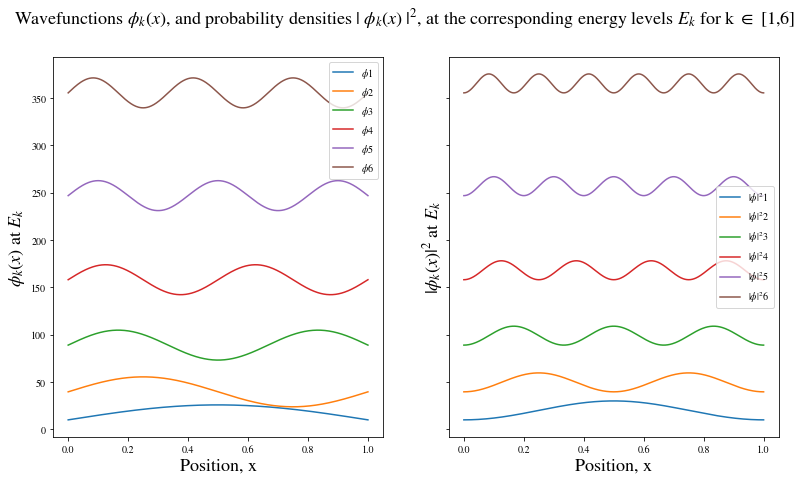

In [881]:
eigvals, eigvecs, prob_density, x, v = schrodinger(499,1)
plot_wavefunctions(x,eigvals, eigvecs, prob_density)

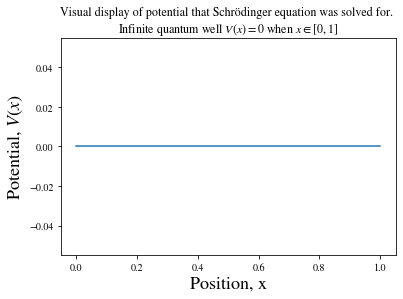

In [896]:
plot_potential(x,v,"Infinite quantum well $V(x) = 0$ when $x \in [0,1]$")

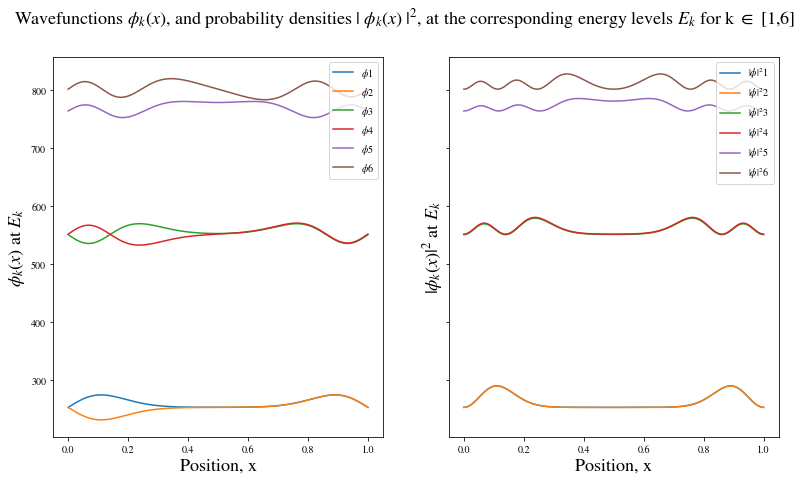

In [886]:
eigvals_1, eigvecs_1, prob_density_1, x_1, v_1 = schrodinger(499,1, "V_1")
plot_wavefunctions(x_1,eigvals_1,eigvecs_1,prob_density_1)

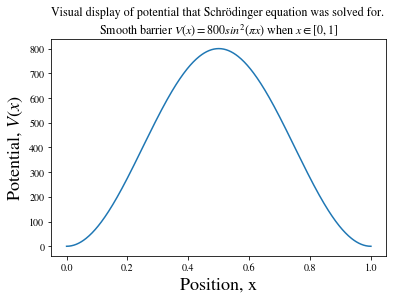

In [897]:
plot_potential(x,v_1,"Smooth barrier $V(x) = 800sin^2(\pi x)$ when $x \in [0,1]$")

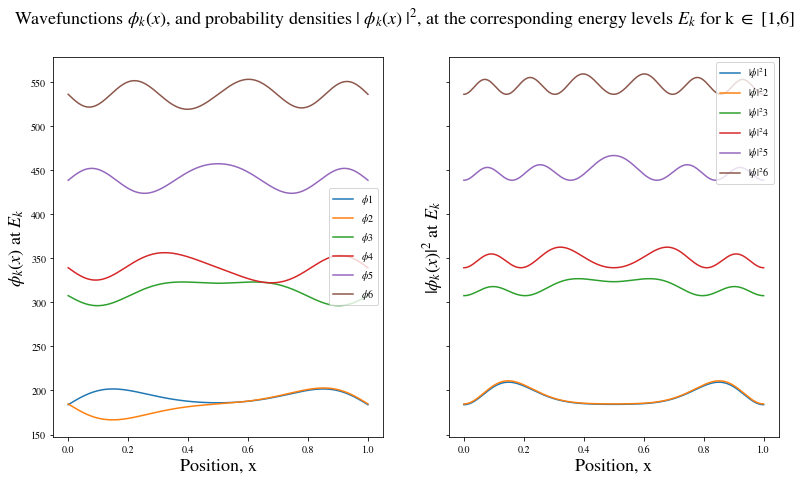

In [888]:
eigvals_2, eigvecs_2, prob_density_2, x_2, v_2 = schrodinger(499,1, "V_2")
plot_wavefunctions(x_2,eigvals_2,eigvecs_2,prob_density_2)

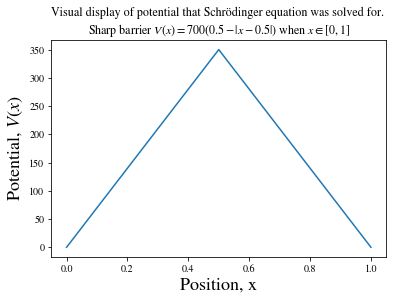

In [898]:
plot_potential(x,v_2,"Sharp barrier $V(x) = 700(0.5 - |x - 0.5|)$ when $x \in [0,1]$")

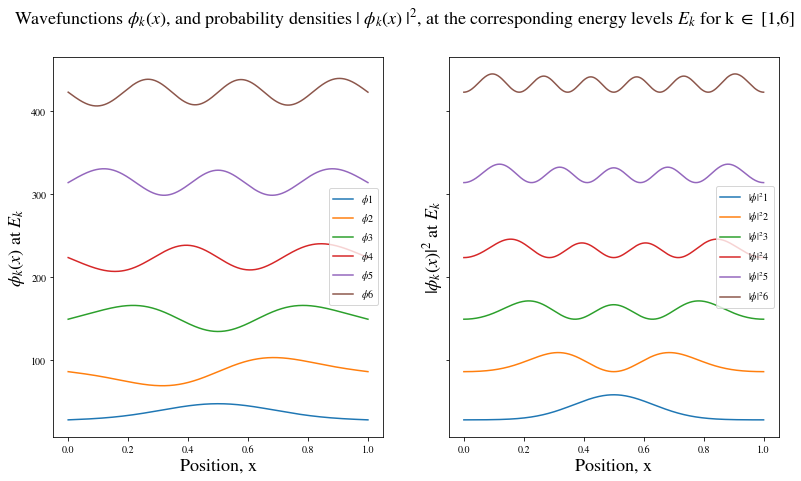

In [890]:
eigvals_3, eigvecs_3, prob_density_3, x_3, v_3 = schrodinger(499,1, "V_3")
plot_wavefunctions(x_3,eigvals_3,eigvecs_3,prob_density_3)

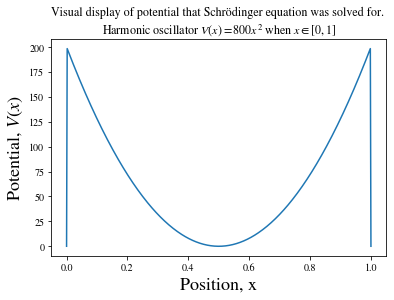

In [900]:
plot_potential(x,v_3,"Harmonic oscillator $V(x) = 800x^2$ when $x \in [0,1]$")

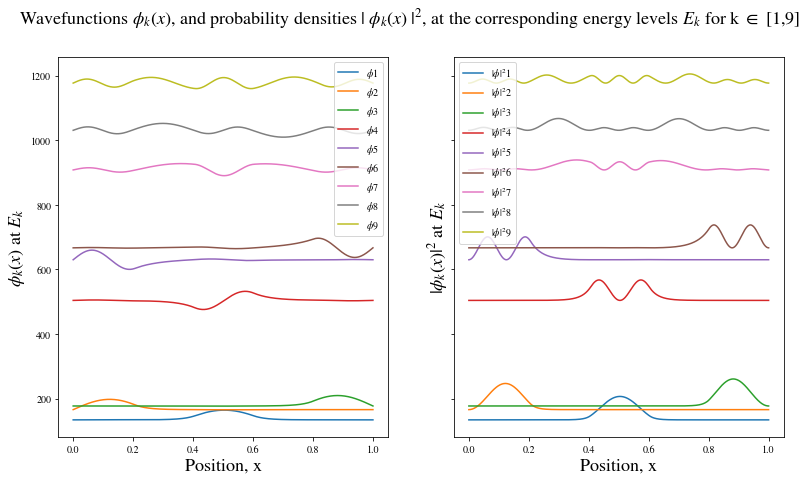

In [127]:
eigvals_4, eigvecs_4, prob_density_4, x_4, v_4 = schrodinger(499,1, "V_4")
plot_wavefunctions(x_4,eigvals_4,eigvecs_4,prob_density_4, nbr = 9)

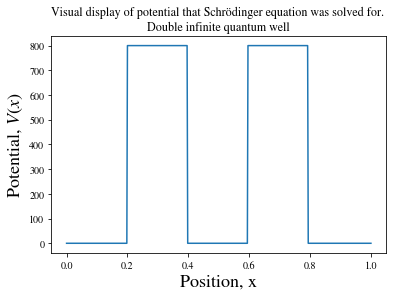

In [901]:
plot_potential(x,v_4,"Double infinite quantum well")

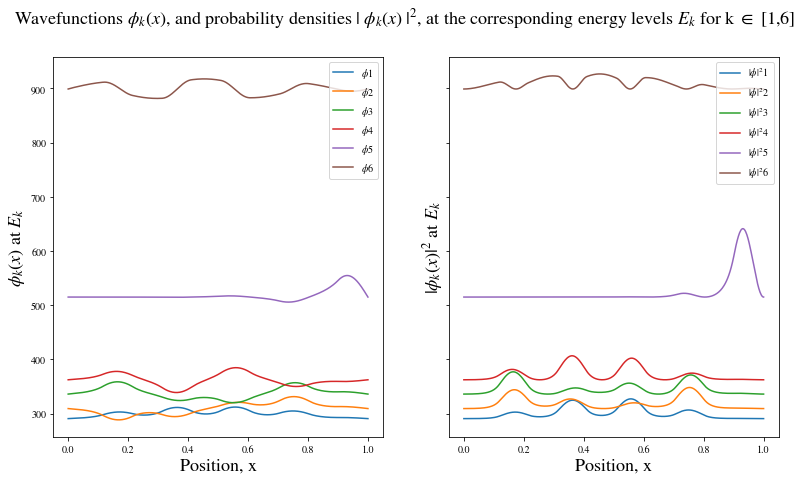

In [903]:
eigvals_5, eigvecs_5, prob_density_5, x_5, v_5 = schrodinger(499,1, "V_5")
plot_wavefunctions(x_5,eigvals_5,eigvecs_5,prob_density_5, nbr = 6)

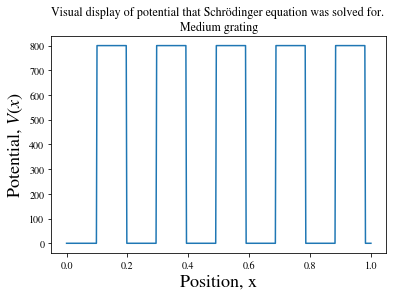

In [996]:
plot_potential(x_5,v_5,"Medium grating")

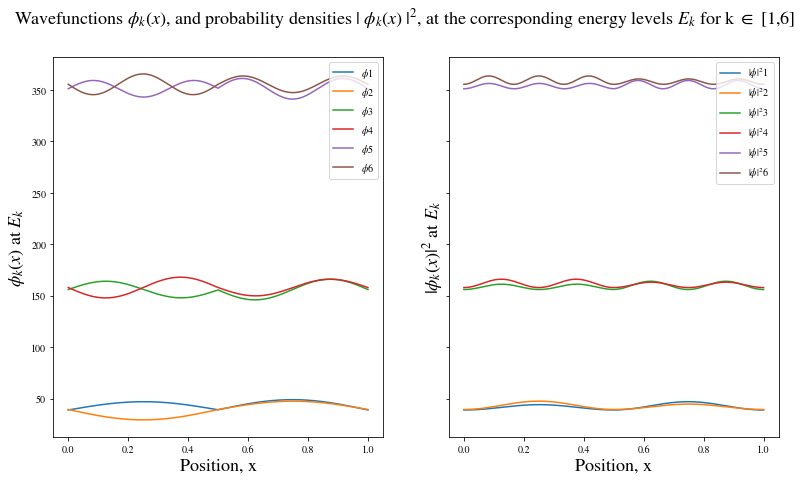

In [905]:
eigvals_6, eigvecs_6, prob_density_6, x_6, v_6 = schrodinger(1500,1, "V_6")
plot_wavefunctions(x_6,eigvals_6,eigvecs_6,prob_density_6, nbr = 6)

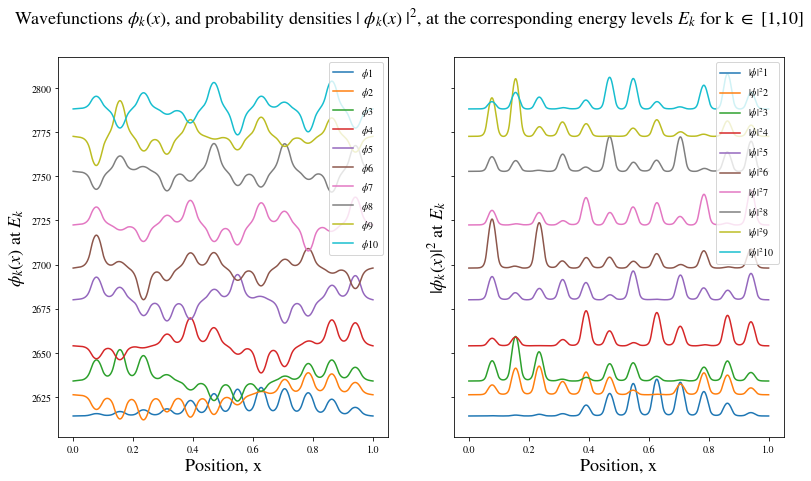

In [126]:
eigvals_7, eigvecs_7, prob_density_7, x_7, v_7 = schrodinger(1500,1, "V_7")
plot_wavefunctions(x_7,eigvals_7,eigvecs_7,prob_density_7, nbr = 10)

eigvals_7, eigvecs_7, prob_density_7, x_7, v_7 = schrodinger(1500,1, "V_7")
plot_wavefunctions(x_7,eigvals_7,eigvecs_7,prob_density_7, nbr = 10)

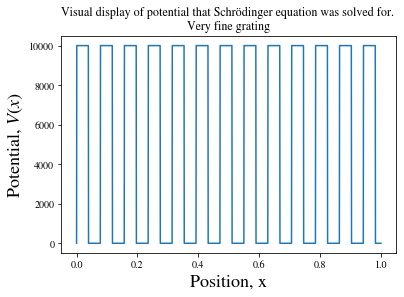

In [912]:
plot_potential(x_6,v_7,"Very fine grating")

In [123]:
v_7

NameError: name 'v_7' is not defined